In [1]:
import sys
sys.path.insert(0, '../..')

from keras.models import load_model
from keras import backend as K
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.transform import rescale
import numpy.ma as ma
import numpy as np
import copy

from pyphoon.io.h5 import read_source_image, read_source_images

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


**Note**: To save the figures uncomment the `plt.savefig` commands and replace the path. 

In [2]:
# Load model
model = load_model('../../tasks/tcxtc/model_tcxtc_1.h5')

## 1. Visualize weights

Let us visualize the weights of the model. We only focus on the first layer's weights, since the rest is too abstract.

In [3]:
# Get weights
model.layers
all_weights = []
for layer in model.layers:
    w = layer.get_weights()
    all_weights.append(w)
# indices conv: 0, 4, 8
# indices dense: 13, 17 
weights = {
    'conv': [all_weights[0][0], all_weights[4][0], all_weights[8][0]],
    'dense':  [all_weights[13][0], all_weights[17][0], all_weights[-1][0]]
}

In [4]:
# Utility functions
# code from: https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb
def nice_imshow(ax, data, colorbar=False, vmin=None, vmax=None, cmap=None, barsize=None):
    """Wrapper around pl.imshow"""
    #if cmap is None:
    #    cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    if colorbar:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        if barsize:
            cbar.ax.tick_params(labelsize=barsize) 
    
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic


In [5]:
W = np.swapaxes(weights['conv'][0], 1, 2)
W = np.swapaxes(W, 0, 1)
W = np.swapaxes(W, 0, 3)[:, :, :, 0]

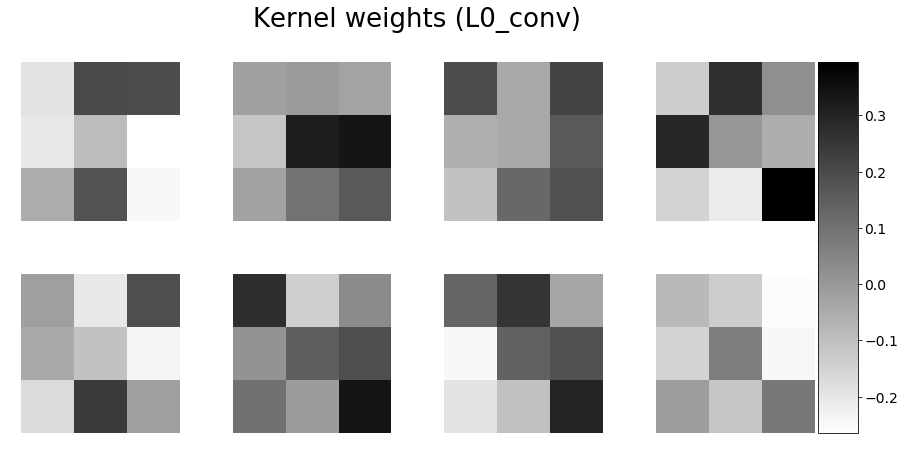

In [6]:
plt.figure(figsize=(15, 15))
plt.title('Kernel weights (L0_conv)', fontsize=26, y=1.08)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(W, 2, 4), cmap=cm.binary, colorbar=True, barsize=14)
#plt.savefig('../_assets/weights_tcxtc.eps', format='eps')

## 2. Check intermediate feature maps
An artificial neural network may be regarded as a black box. To mitigate this feeling, in this section we look at the activation maps throughout the different network layers when we input a particular image. We will use images from sequence `200003` (training set), which includes TC and xTC samples.

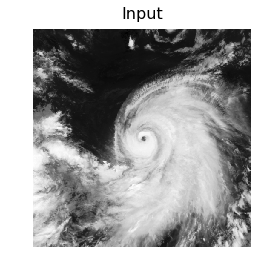

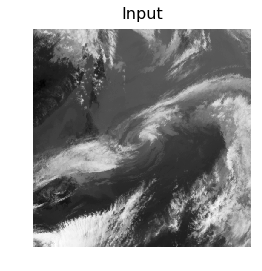

In [7]:
# TODO: Do this using pd_man
# Load one image from validation set
#X = read_source_image('../../pyphoon/original_data/image/200111/2001081915-200111-GMS5-1.h5')
X_tc = read_source_image('/root/fs9/datasets/typhoon/wnp/image/200003/2000070507-200003-GMS5-1.h5')
plt.imshow(X_tc, 'Greys')
plt.axis('off')
plt.title('Input', fontsize=16, y=1.02)
#plt.savefig('../_assets/example_activation_input_tc.eps', format='eps')
plt.show()

X_xtc = read_source_image('/root/fs9/datasets/typhoon/wnp/image/200003/2000070907-200003-GMS5-1.h5')
plt.imshow(X_xtc, 'Greys')
plt.axis('off')
plt.title('Input', fontsize=16, y=1.02)
#plt.savefig('../_assets/example_activation_input_xtc.eps', format='eps')
plt.show()

In [8]:
# Function to get activation specific layer
# from: https://github.com/keras-team/keras/issues/41
def get_activations(model, layer, X, preprocess_algorithm=None, dense=False, expand=False):
    if preprocess_algorithm:
        X = preprocess_algorithm(X)
    _get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = _get_activations([X, 0])
    if dense:
        if expand:
            return np.vstack([activations[0]]*10)
        else:
            return activations[0]
    else:
        return np.swapaxes(activations[0], 0, 3)[:, :, :, 0]

### 2.1 Plot conv layers

In [9]:
# Preprocess algorithm
from pyphoon.app.preprocess import DefaultImagePreprocessor
preprocessor = DefaultImagePreprocessor(mean=269.15, std=24.14, resize_factor=2, reshape_mode='keras')

#### TC

8
16
32


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:388: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


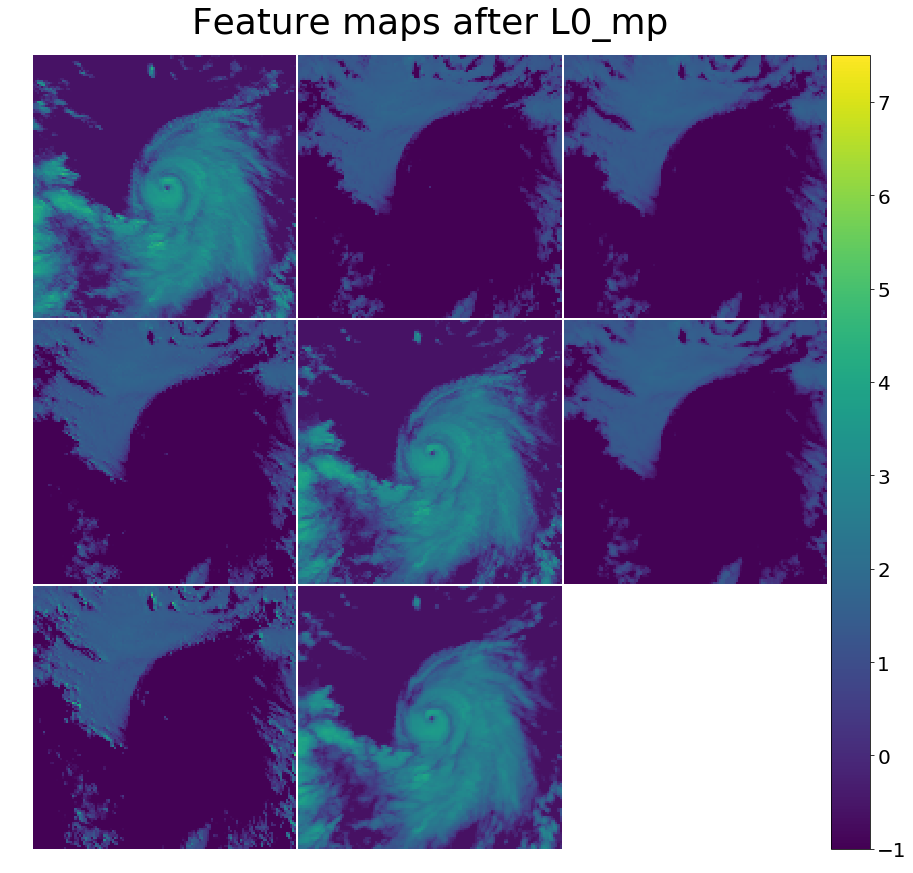

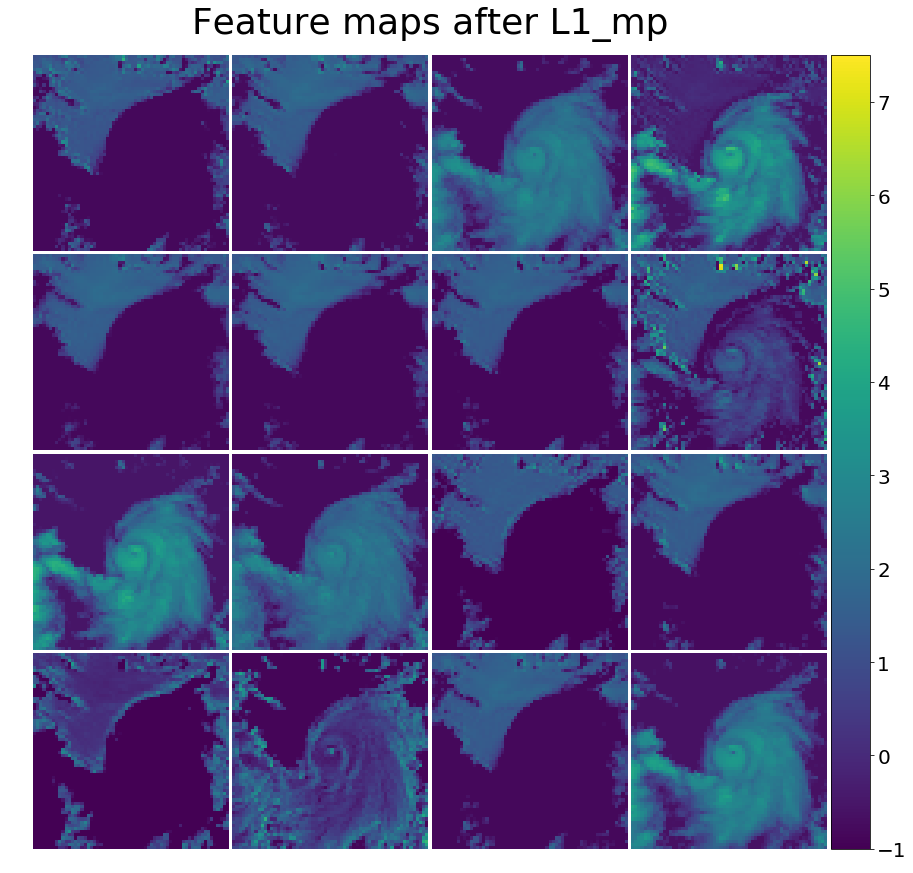

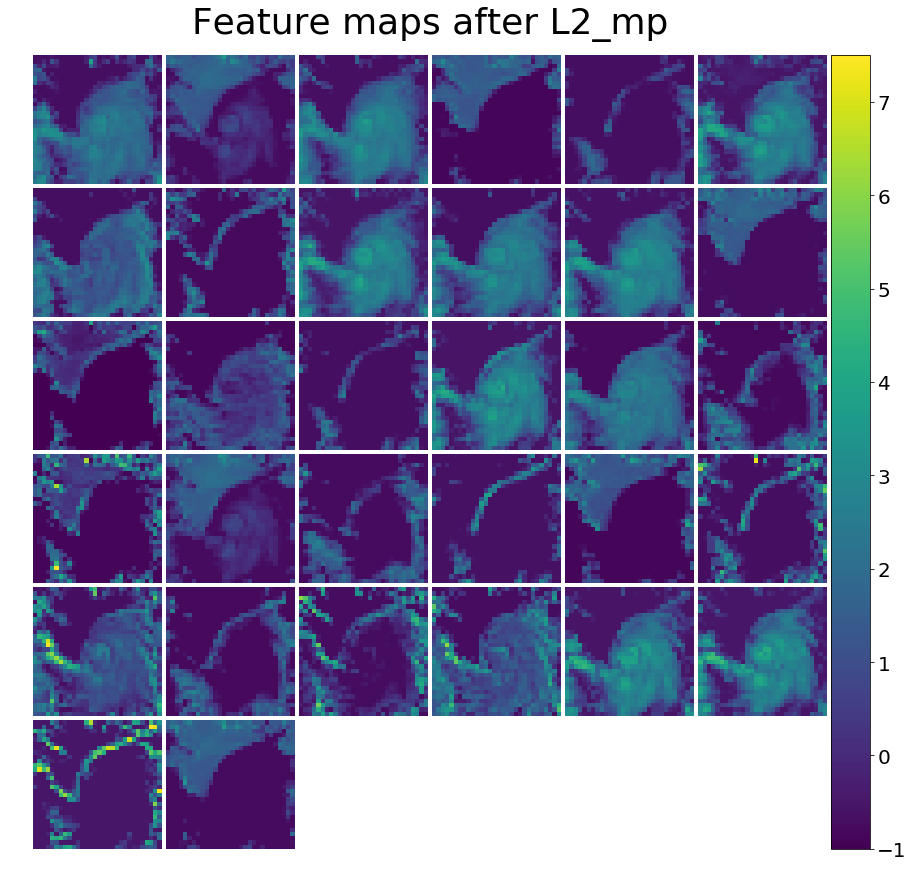

In [10]:
# conv: 3, 7, 11
layer = 3
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_tc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L0_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 3, 3), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l0_tc.eps', format='eps')

layer = 7
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_tc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L1_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 4, 4), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l1_tc.eps', format='eps')

layer = 11
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_tc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L2_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 6, 6), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l2_tc.eps', format='eps')

#### xTC

8
16
32


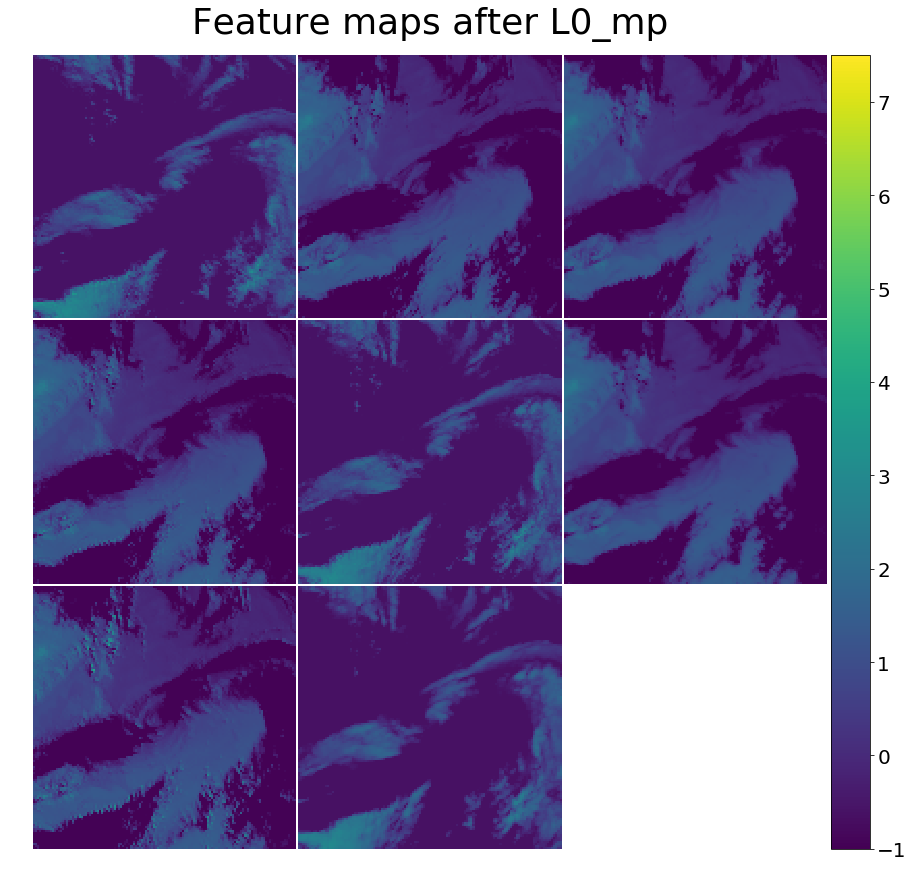

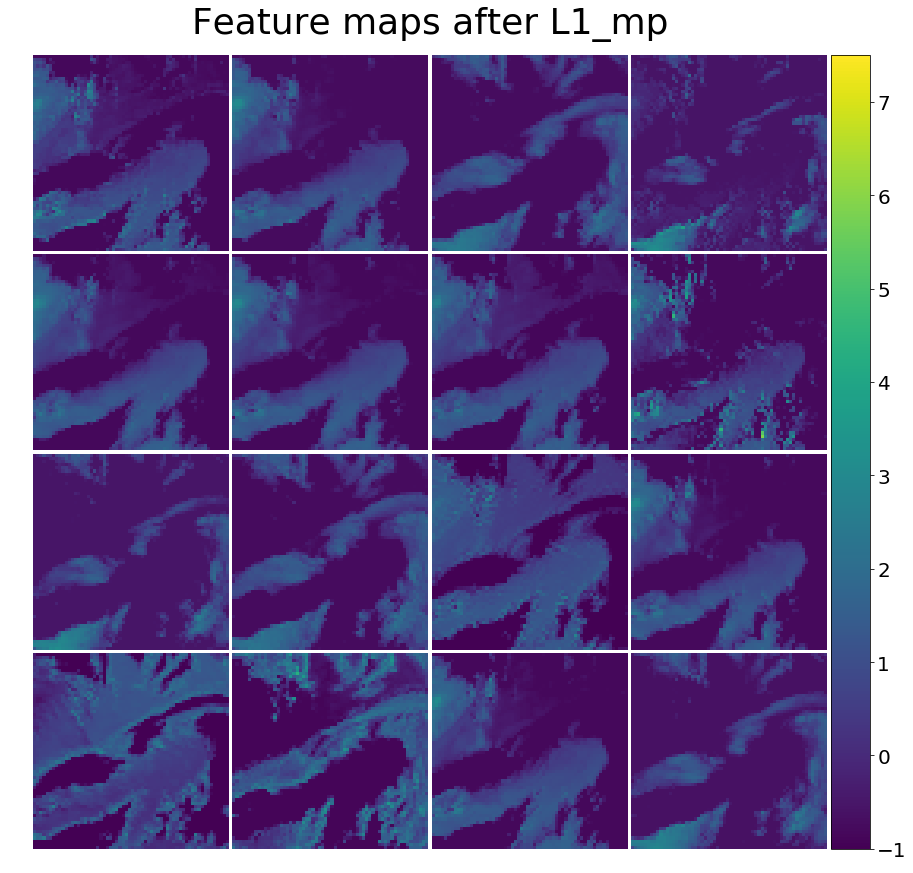

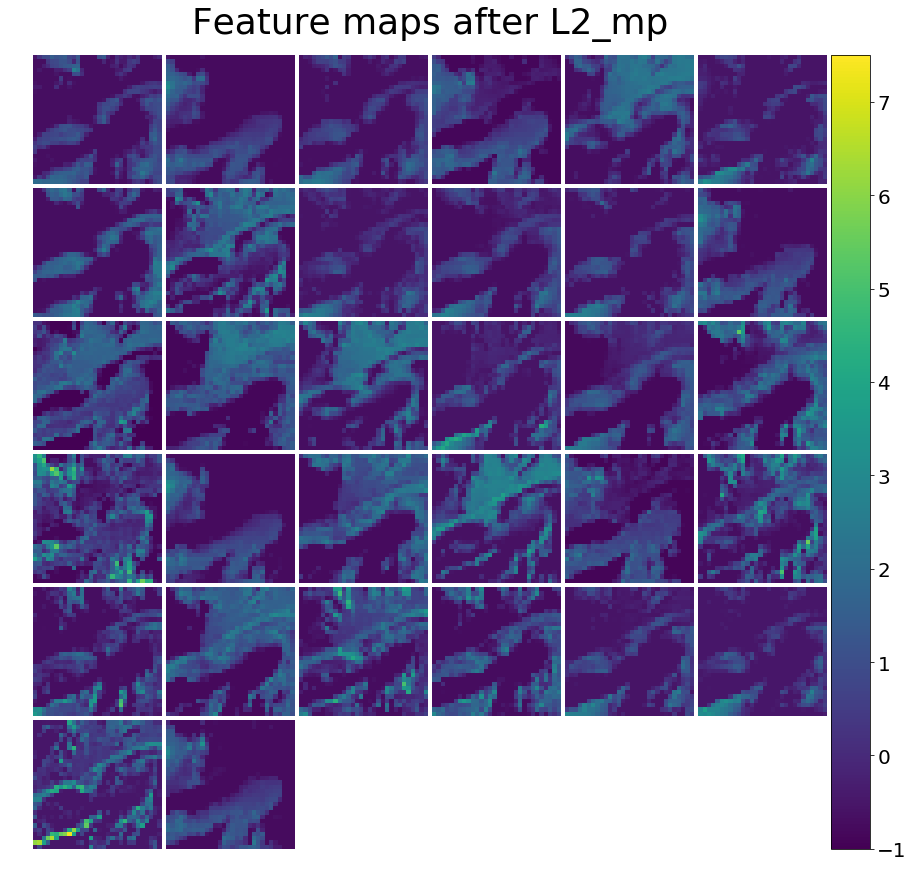

In [11]:
layer = 3
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_xtc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L0_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 3, 3), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l0_xtc.eps', format='eps')

layer = 7
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_xtc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L1_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 4, 4), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l1_xtc.eps', format='eps')

layer = 11
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_xtc, axis=0), preprocess_algorithm=preprocessor.apply)
print(len(C))
plt.figure(figsize=(15, 15))
plt.title('Feature maps after L2_mp', fontsize=36, y=1.02)
plt.axis('off')
nice_imshow(plt.gca(), make_mosaic(C, 6, 6), vmin=-1, vmax=7.5, colorbar=True, barsize=20)
# plt.savefig('../_assets/example_activation_l2_xtc.eps', format='eps')

### 2.2 Plot dense layer

#### TC

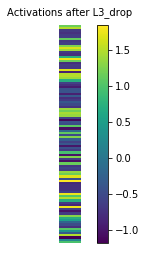

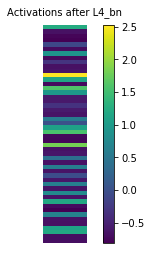

In [12]:
# dense: 16, 19, 20
layer = 16
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_tc, axis=0), preprocess_algorithm=preprocessor.apply, dense=True, expand=True)
plt.gcf().clear()
im = plt.imshow(C.T)
plt.colorbar(im)
plt.axis('off')
plt.title('Activations after L3_drop', fontsize=10, y=1.02)
# plt.savefig('../_assets/example_activation_l3_tc.eps', format='eps')
plt.show()

layer = 19
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_tc, axis=0), preprocess_algorithm=preprocessor.apply, dense=True, expand=True)
plt.gcf().clear()
im = plt.imshow(C.T)
plt.axis('off')
plt.colorbar(im)
plt.title('Activations after L4_bn', fontsize=10, y=1.02)
# plt.savefig('../_assets/example_activation_l4_tc.eps', format='eps')
plt.show()


#### xTC

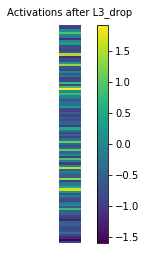

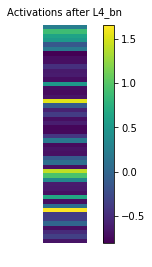

In [13]:
# dense: 16, 19, 20
layer = 16
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_xtc, axis=0), preprocess_algorithm=preprocessor.apply, dense=True, expand=True)
plt.gcf().clear()
im = plt.imshow(C.T)
plt.colorbar(im)
plt.axis('off')
plt.title('Activations after L3_drop', fontsize=10, y=1.02)
# plt.savefig('../_assets/example_activation_l3_tc.eps', format='eps')
plt.show()

layer = 19
print(model.layers[layer])
C = get_activations(model, layer, np.expand_dims(X_xtc, axis=0), preprocess_algorithm=preprocessor.apply, dense=True, expand=True)
plt.gcf().clear()
im = plt.imshow(C.T)
plt.axis('off')
plt.colorbar(im)
plt.title('Activations after L4_bn', fontsize=10, y=1.02)
# plt.savefig('../_assets/example_activation_l4_tc.eps', format='eps')
plt.show()


## 4. Feature attribution
In this section we will try to find out which regions in the image are the most relevant for the network. First, we define couple of functions that will come in hand. Next, we obtain the feature attribution images for each of the classes (i.e. TC and xTC).

In [14]:
def get_patched_images(X, patch_size, stride, patch):
    m_max = X.shape[1]-patch_size
    n_max = X.shape[2]-patch_size

    # Add patch to image
    X_patch = []
    for n in range(0, n_max+1, stride):
        for m in range(0, m_max+1, stride):
            X_ = copy.copy(X)
            X_[0, n:n+patch_size, m:m+patch_size, 0] =  patch#np.random.randn(patch_sz, patch_sz)#-1.5
            X_patch.append(X_)
    X_patch = np.vstack(X_patch)
    return X_patch

def predictions2image_reshape(predictions, scale):
    sz = int(np.sqrt(len(predictions)))
    attribution_image = predictions.reshape(sz, sz)
    return rescale(attribution_image, scale) # scale origina image size

def get_attribution_image(X, patch_size, stride, patch):
    # Get patched images
    X_patch = get_patched_images(X, patch_size=patch_size, stride=stride, patch=patch)

    # Do predictions
    predictions = model.predict(X_patch)[:,0]
    # Get worst results
    worst_results_loc = predictions.argsort()[:30]
    worst_results_val = predictions[worst_results_loc]

    # Reshape to obtain image
    attribution_image = predictions2image_reshape(predictions, stride)
    
    return predictions, attribution_image, X_patch, worst_results_loc, worst_results_val

### xTC

In [15]:
# Load image
# X = read_source_image('../../pyphoon/original_data/image/200003/2000070907-200003-GMS5-1.h5')
X = preprocessor.apply(np.expand_dims(X_xtc,0))

# Reshape to obtain image
predictions={}
attribution_image={}
X_patch={}
worst_results_loc={}
worst_results_val={}

patches = [np.min(X), np.mean(X), np.max(X)]

for patch in patches:
    print(patch)
    predictions[patch], attribution_image[patch], X_patch[patch], worst_results_loc[patch], worst_results_val[patch] = get_attribution_image(
        X, patch_size=40, stride=4, patch=patch
    )

-2.52800648302


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.0943420890026
1.49190052817


Worst result: 0.0312858502148


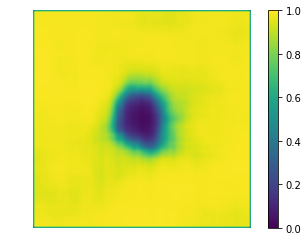

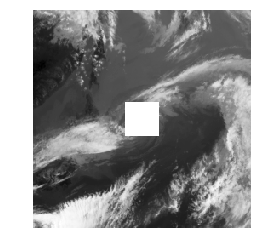

Worst result: 0.954155504704


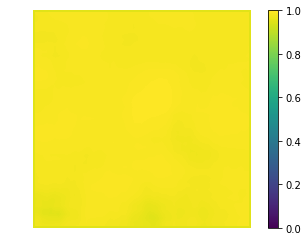

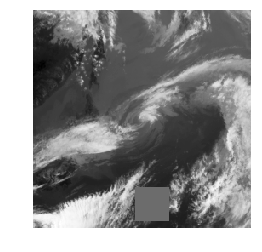

Worst result: 0.413863331079


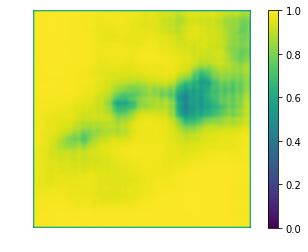

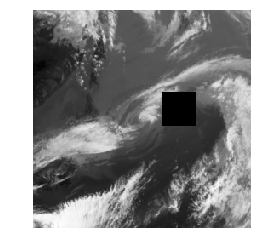

In [16]:
# Plot attribution image
#plt.figure(figsize=(10, 6))
idx = 0

count = 0
for patch in patches:
    # Plot attribution image
    plt.gcf().clear()
    im = plt.imshow(attribution_image[patch], vmin=0, vmax=1)
    plt.colorbar(im)
    plt.axis('off')
    # plt.savefig('../_assets/attribution_img_tcxtc_xtc_map'+str(count)+'.eps', format='eps')
    print("Worst result:", np.min(attribution_image[patch]))
    count += 1
    plt.show()
    
    # Plot image with patch for worst case
    plt.imshow(X_patch[patch][worst_results_loc[patch][idx],:,:,0], cmap="Greys")
    plt.axis('off')
    # plt.savefig('../_assets/attribution_img_tcxtc_xtc_img'+str(count)+'.eps', format='eps')
    count += 1
    plt.show()

### TC

In [17]:
# Load image
X = preprocessor.apply(np.expand_dims(X_tc,0))

# Reshape to obtain image
predictions={}
attribution_image={}
X_patch={}
worst_results_loc={}
worst_results_val={}

patches = [np.min(X), np.mean(X), np.max(X)]

for patch in patches:
    print(patch)
    predictions[patch], attribution_image[patch], X_patch[patch], worst_results_loc[patch], worst_results_val[patch] = get_attribution_image(
        X, patch_size=120, stride=4, patch=patch
    )

-3.31620470174


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


-0.613759785553
1.32365832643


Worst result: 0.0550281241885


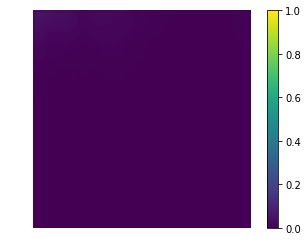

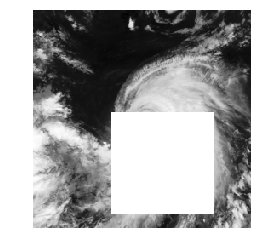

Worst result: 0.40857146075


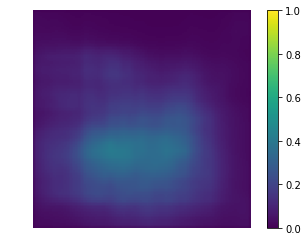

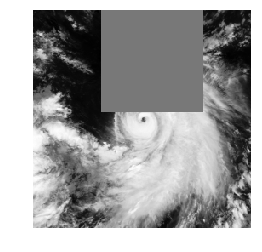

Worst result: 0.253923697863


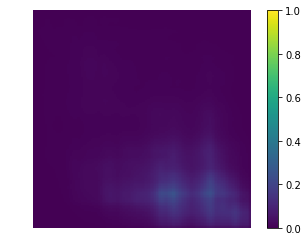

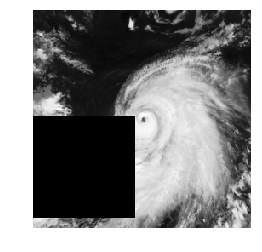

In [18]:
# Plot attribution image
idx = 0

count = 0
for patch in patches:
    # Plot attribution image
    plt.gcf().clear()
    im = plt.imshow(attribution_image[patch], vmin=0, vmax=1)
    plt.colorbar(im)
    plt.axis('off')
    # plt.savefig('../_assets/attribution_img_tcxtc_tc_map'+str(count)+'.eps', format='eps')
    print("Worst result:", np.max(attribution_image[patch]))
    count += 1
    plt.show()
    
    # Plot image with patch for worst case
    plt.imshow(X_patch[patch][worst_results_loc[patch][idx],:,:,0], cmap="Greys")
    plt.axis('off')
    # plt.savefig('../_assets/attribution_img_tcxtc_tc_img'+str(count)+'.eps', format='eps')
    count += 1
    plt.show()
